In [1]:
import sys
from __future__ import annotations

In [5]:
from src.model_clay import CLAYModule
#import src.datamodule
#from src.datamodule import ClayDataset, ClayDataModule
from src.datamodule_eval_local import ClayDataset, ClayDataModule
import pandas as pd
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import einops
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import rasterio as rio
from einops import rearrange, reduce
import torch
import lightning as L
from pytorch_lightning import LightningModule, Trainer
from einops import rearrange
import torchmetrics

In [6]:
data_dir = "../data/"

### Get the benchmark data

In [ ]:
import boto3

def list_objects_recursive(client, bucket_name, prefix=""):
    """
    List all objects (file keys) in an S3 bucket recursively under a specified prefix.

    Args:
    - client (boto3.client): An initialized Boto3 S3 client.
    - bucket_name (str): The name of the S3 bucket.
    - prefix (str): The prefix (directory path) within the bucket to search for objects (optional).

    Returns:
    - list: A list of file keys (object keys) found under the specified prefix.
    """
    paginator = client.get_paginator("list_objects_v2")

    page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

    file_keys = []
    for page in page_iterator:
        if "Contents" in page:
            file_keys.extend([obj["Key"] for obj in page["Contents"]])

    return file_keys

In [ ]:
import os
def get_image_granules(bucket_name, prefix):
    """
    Get granules of N-dim datacube and label images from an S3 bucket.

    Args:
    - bucket_name (str): The name of the S3 bucket.
    - prefix (str): The prefix (directory path) in the S3 bucket.

    Returns:
    - tuple: None.
    """
    # Initialize Boto3 S3 client
    session = boto3.Session(aws_access_key_id='', aws_secret_access_key='',)

    s3 = session.client('s3')

    # List objects in the specified prefix (directory) in the bucket
    files_in_s3 = list_objects_recursive(s3, bucket_name, prefix)

    # Filter S2 and S1 images
    S1_labels = [i for i in files_in_s3 if "LabelWater.tif" in i] # Ground truth
    S2_labels = [i for i in files_in_s3 if "LabelCloud.tif" in i] # Cloud and cloud shadow masks
    datacube_images = [f"{i[:-15]}.tif" for i in S1_labels]

    for i in datacube_images:
        k = "/".join(i.split('/')[3:])
        id_dir = i.split('/')[3]
        if not os.path.exists(f"../data/{id_dir}"):
          os.makedirs(f"../data/{id_dir}")

        local_file_path = f"../data/{k}"

        # Download the object from S3 to the local file
        s3.download_file(bucket_name, i, local_file_path)

    for i in S1_labels:
        k = "/".join(i.split('/')[3:])
        local_file_path = f"../data/{k}"
        id_dir = i.split('/')[3]
        if not os.path.exists(f"../data/{id_dir}"):
          os.makedirs(f"../data/{id_dir}")
        # Download the object from S3 to the local file
        s3.download_file(bucket_name, i, local_file_path)

    for i in S2_labels:
        k = "/".join(i.split('/')[3:])
        local_file_path = f"../data/{k}"
        id_dir = i.split('/')[3]
        if not os.path.exists(f"../data/{id_dir}"):
          os.makedirs(f"../data/{id_dir}")
        # Download the object from S3 to the local file
        s3.download_file(bucket_name, i, local_file_path)


get_image_granules(bucket_name="clay-benchmark", prefix="c2smsfloods/datacube/chips_512_v2/")

### Generate and visualize an embedding

In [ ]:
model = CLAYModule.load_from_checkpoint("../clay-small-70MT-1100T-10E.ckpt", mask_ratio=0.)
model.eval();

In [ ]:
dm = ClayDataModule(data_dir=data_dir, batch_size=4)

In [ ]:
dm.setup()

In [ ]:
val_dl = iter(dm.val_dataloader())

In [ ]:
batch = next(val_dl)

In [ ]:
batch

{'labels': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           ...,
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
     

In [ ]:
batch["pixels"] = batch["pixels"].to(model.device)
batch["timestep"] = batch["timestep"].to(model.device)
batch["latlon"] = batch["latlon"].to(model.device)
emb = model.model.encoder(batch)

In [ ]:
emb

(tensor([[[-0.0207,  0.0040, -0.0031,  ..., -0.0153, -0.0023, -0.0215],
          [-0.0361, -0.0165, -0.0014,  ..., -0.0104, -0.0196, -0.0116],
          [-0.0198, -0.0168, -0.0021,  ..., -0.0026, -0.0113,  0.0059],
          ...,
          [ 0.0061,  0.0179,  0.0069,  ...,  0.0246, -0.0303,  0.0283],
          [-0.0233, -0.0531, -0.0135,  ..., -0.0153, -0.1828, -0.0428],
          [ 0.0159, -0.0671,  0.0113,  ...,  0.0063, -0.1040, -0.0415]],
 
         [[-0.0181, -0.0382, -0.0059,  ..., -0.0246, -0.0263,  0.0039],
          [-0.0184, -0.0442, -0.0058,  ..., -0.0274, -0.0379, -0.0068],
          [-0.0157, -0.0191, -0.0019,  ..., -0.0251, -0.0222, -0.0033],
          ...,
          [ 0.0084,  0.0146,  0.0063,  ...,  0.0120, -0.0348,  0.0317],
          [-0.0074, -0.0218, -0.0041,  ..., -0.0109, -0.0418, -0.0053],
          [ 0.0233, -0.0622,  0.0007,  ..., -0.0178, -0.0716, -0.0345]],
 
         [[-0.0191,  0.0016, -0.0023,  ..., -0.0089, -0.0164,  0.0009],
          [-0.0249, -0.0086,

In [ ]:
emb = emb[0]

In [ ]:
emb

tensor([[[-0.0207,  0.0040, -0.0031,  ..., -0.0153, -0.0023, -0.0215],
         [-0.0361, -0.0165, -0.0014,  ..., -0.0104, -0.0196, -0.0116],
         [-0.0198, -0.0168, -0.0021,  ..., -0.0026, -0.0113,  0.0059],
         ...,
         [ 0.0061,  0.0179,  0.0069,  ...,  0.0246, -0.0303,  0.0283],
         [-0.0233, -0.0531, -0.0135,  ..., -0.0153, -0.1828, -0.0428],
         [ 0.0159, -0.0671,  0.0113,  ...,  0.0063, -0.1040, -0.0415]],

        [[-0.0181, -0.0382, -0.0059,  ..., -0.0246, -0.0263,  0.0039],
         [-0.0184, -0.0442, -0.0058,  ..., -0.0274, -0.0379, -0.0068],
         [-0.0157, -0.0191, -0.0019,  ..., -0.0251, -0.0222, -0.0033],
         ...,
         [ 0.0084,  0.0146,  0.0063,  ...,  0.0120, -0.0348,  0.0317],
         [-0.0074, -0.0218, -0.0041,  ..., -0.0109, -0.0418, -0.0053],
         [ 0.0233, -0.0622,  0.0007,  ..., -0.0178, -0.0716, -0.0345]],

        [[-0.0191,  0.0016, -0.0023,  ..., -0.0089, -0.0164,  0.0009],
         [-0.0249, -0.0086, -0.0100,  ..., -0

In [ ]:
emb[0].shape

torch.Size([1538, 768])

In [ ]:
from einops import rearrange

embeddings = emb#[0]
print(embeddings.shape)
embeddings = embeddings[:,:-2,:]
print(embeddings.shape)
latent = rearrange(embeddings, "b (g l) d  -> b g l d", g=6)
latent = rearrange(latent, "b g (h w) d -> b g h w d", h=16, w=16)
latent = rearrange(latent, "b g h w d -> b (g d) h w")
print(latent.shape)


torch.Size([4, 1538, 768])
torch.Size([4, 1536, 768])
torch.Size([4, 4608, 16, 16])


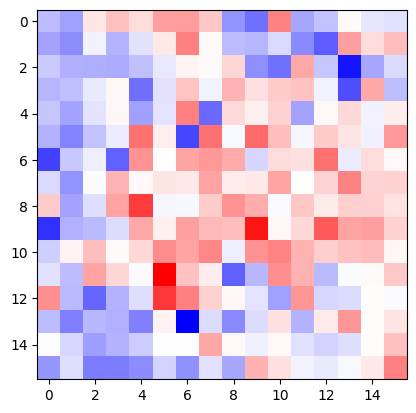

In [ ]:
plt.imshow(latent[1][1].detach().numpy(), cmap="bwr")

In [ ]:
batch["pixels"][0].permute(1,2,0)[:,:,11].detach().numpy()

array([[-0.01246017, -0.02784646, -0.0444915 , ...,  0.09696781,
         0.21106492,  0.11906873],
       [-0.00763035, -0.00441564, -0.01447678, ...,  0.04624269,
         0.13017079,  0.08654074],
       [-0.0275357 , -0.02705069,  0.00513181, ..., -0.01385808,
         0.02237789,  0.0461733 ],
       ...,
       [-0.0451439 ,  0.0447403 ,  0.1230152 , ..., -0.01493489,
        -0.0518337 , -0.08400981],
       [-0.04823124,  0.06080151,  0.08305081, ..., -0.05319439,
        -0.08664446, -0.09089882],
       [-0.07881664, -0.02791659,  0.01140391, ..., -0.05890915,
        -0.0602114 , -0.05528775]], dtype=float32)

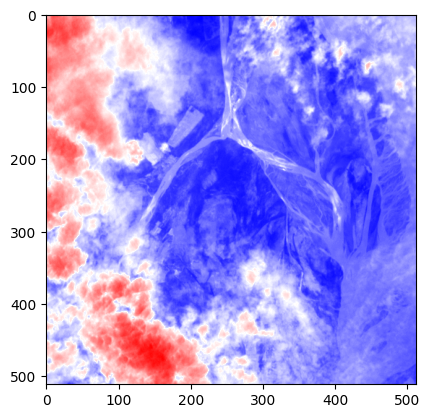

In [ ]:
plt.imshow(batch["pixels"][1].permute(1,2,0)[:,:,2].detach().numpy(), cmap="bwr")

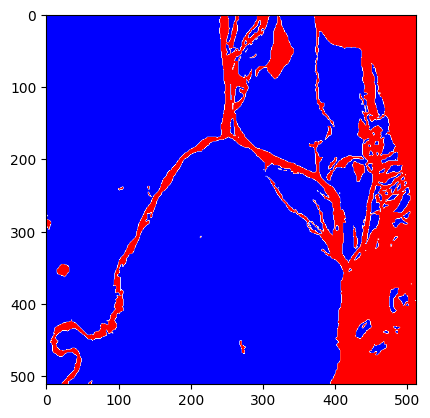

In [ ]:
plt.imshow(batch["labels"][1].permute(1,2,0)[:,:,:].detach().numpy(), cmap="bwr")

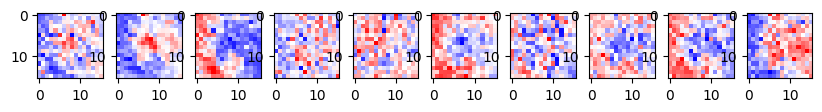

In [ ]:
fig, axs = plt.subplots(1,10,figsize=(10,5))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(latent[1][i+10].detach().numpy(), cmap="bwr")

## Train from scratch

In [7]:
class FloodDetector_fromscratch(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(128, 512, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(512, out_channels, kernel_size=3, padding=1), # output channels = 2 because classes [0,1]
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)
        # Decoder
        x = self.decoder(x1)
        return x


class FloodDetectorLightning_fromscratch(LightningModule):
    def __init__(self, model, datamodule):
        super().__init__()
        self.model = model
        self.datamodule = datamodule

    def forward(self, x):
        return self.model(x)


    def training_step(self, batch, batch_idx):
        torch.set_grad_enabled(True)
        assert torch.is_grad_enabled()
        assert all(p.requires_grad for p in self.parameters())
        print("grad enabled")
        x, y = batch["pixels"], batch["labels"]
        prediction = self.model(x)
        #y = y.squeeze()
        y = torch.tensor(y, requires_grad=False)
        prediction = torch.tensor(prediction.float(), requires_grad=True)
        #prediction = prediction.squeeze()

        # Apply binary cross entropy loss
        loss = torch.nn.functional.binary_cross_entropy(torch.nn.functional.sigmoid(prediction), y.float())
        self.log("train_loss", loss)
        print("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        torch.set_grad_enabled(True)
        assert torch.is_grad_enabled()
        assert all(p.requires_grad for p in self.parameters())
        print("grad enabled")
        x, y = batch["pixels"], batch["labels"]
        prediction = self.model(x)
        #y = y.squeeze()
        y = torch.tensor(y, requires_grad=False)
        prediction = torch.tensor(prediction.float(), requires_grad=True)
        #prediction = prediction.squeeze()

        # Apply binary cross entropy loss
        val_loss = torch.nn.functional.binary_cross_entropy(torch.nn.functional.sigmoid(prediction), y.float())
        print("val_loss", val_loss)
        self.log("val_loss", val_loss)
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        return optimizer

    def train_dataloader(self):
        return self.datamodule.train_dataloader()

    def val_dataloader(self):
        return self.datamodule.val_dataloader()

dm = ClayDataModule(data_dir=data_dir, batch_size=8)
dm.setup()

det_model_ = FloodDetector_fromscratch(13, 1)
model_clay = CLAYModule.load_from_checkpoint("../clay-small-70MT-1100T-10E.ckpt", mask_ratio=0.)
model_clay.eval();
det_model = FloodDetectorLightning_fromscratch(det_model_, dm)

trainer_fromscratch = Trainer(max_epochs=5)
trainer_fromscratch.fit(det_model)

Total number of chips: 339


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params
----------------------------------------------------
0 | model | FloodDetector_fromscratch | 713 K 
----------------------------------------------------
713 K     Trainable params
0         Non-trainable params
713 K     Total params
2.853     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

grad enabled


<ipython-input-7-ce8d7479967b>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, requires_grad=False)
<ipython-input-7-ce8d7479967b>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction = torch.tensor(prediction.float(), requires_grad=True)


val_loss tensor(0.6952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


tensor(0.6940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

grad enabled
train_loss 

<ipython-input-7-ce8d7479967b>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, requires_grad=False)
<ipython-input-7-ce8d7479967b>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction = torch.tensor(prediction.float(), requires_grad=True)


tensor(0.6950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6949, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6945, device='cuda:0', grad_fn=<BinaryCro

Validation: |          | 0/? [00:00<?, ?it/s]

grad enabled
val_loss tensor(0.6952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


grad enabled
train_loss tensor(0.6952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6949, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6948, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6955, device='cud

Validation: |          | 0/? [00:00<?, ?it/s]

grad enabled
val_loss tensor(0.6952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6956, device='cuda:0', grad_fn=<Bin

Validation: |          | 0/? [00:00<?, ?it/s]

grad enabled
val_loss tensor(0.6952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6954, device='cuda:0', grad_fn=<Bin

Validation: |          | 0/? [00:00<?, ?it/s]

grad enabled
val_loss tensor(0.6952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
train_loss tensor(0.6943, device='cuda:0', grad_fn=<Bin

Validation: |          | 0/? [00:00<?, ?it/s]

grad enabled
val_loss tensor(0.6952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


tensor(0.6961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
grad enabled
val_loss tensor(0.6956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


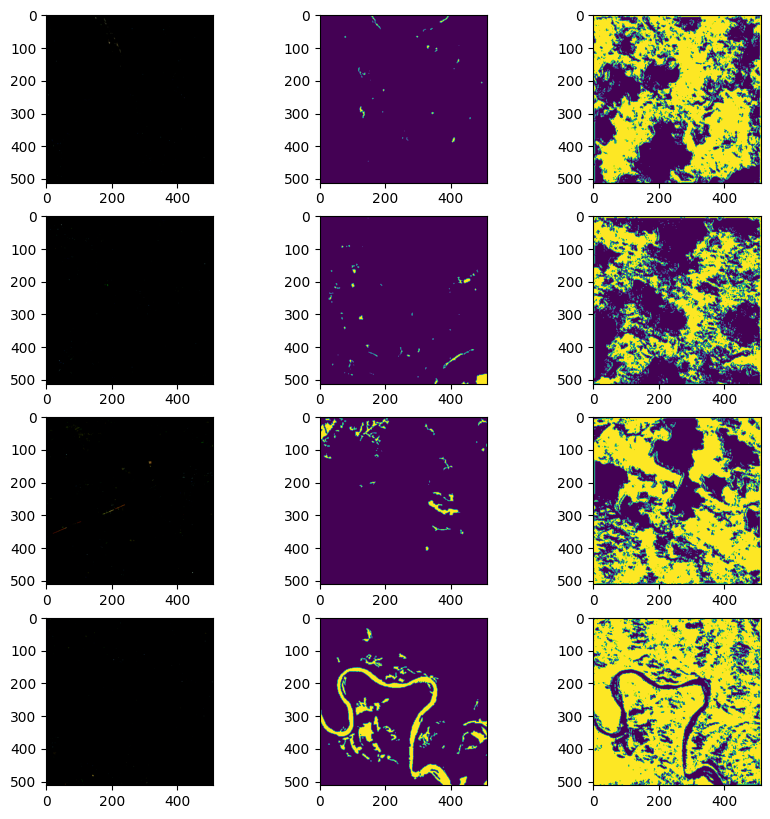

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


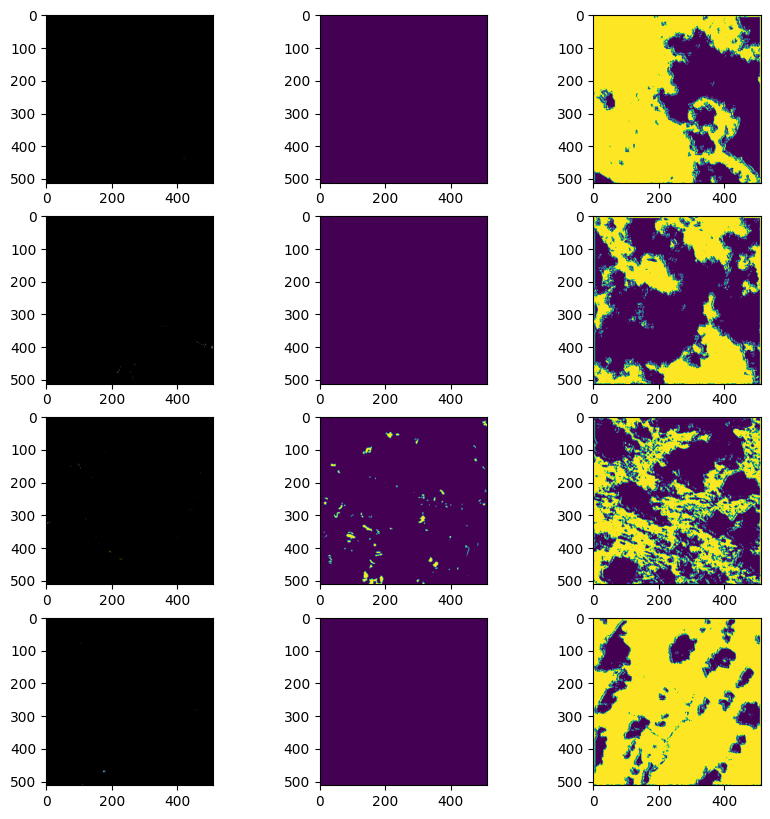

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


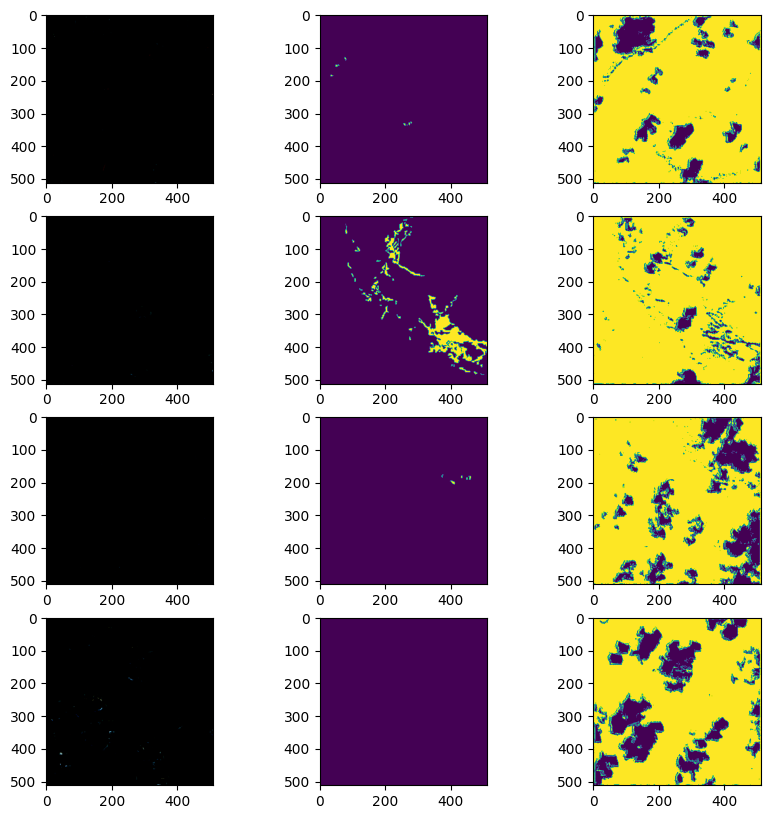

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


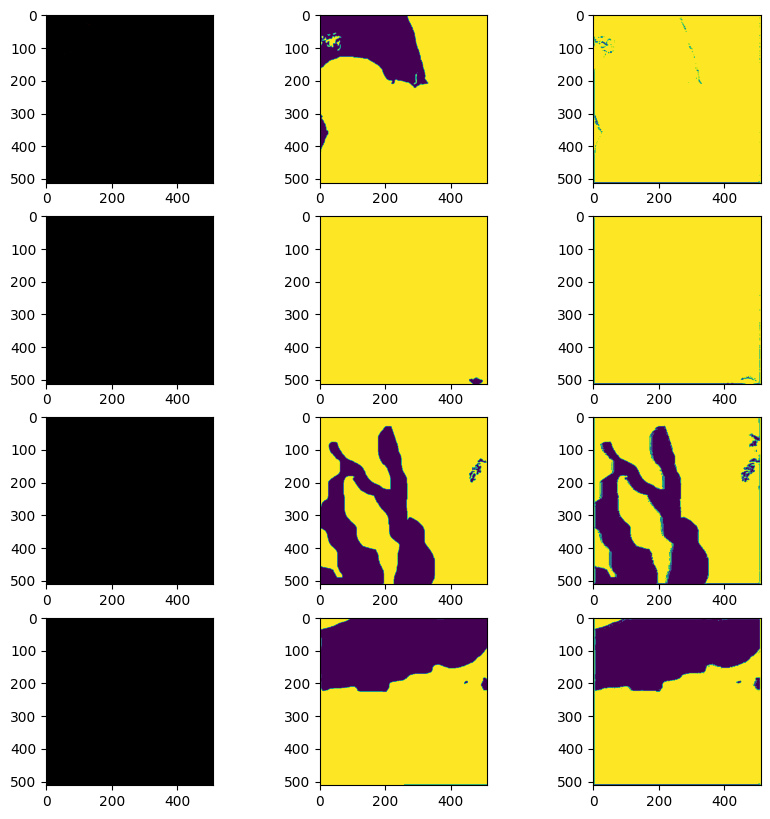

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


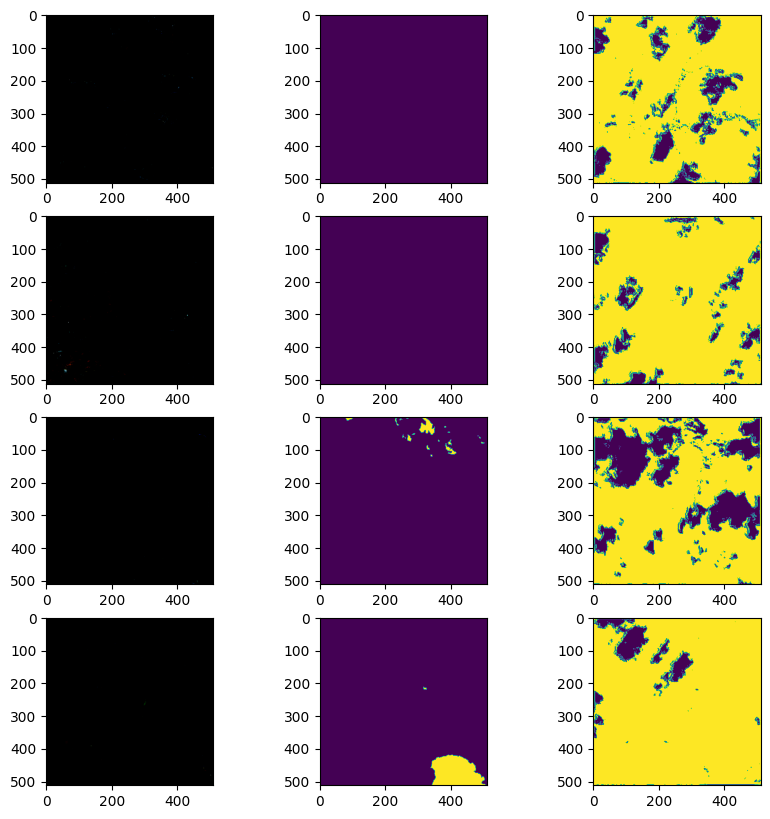

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


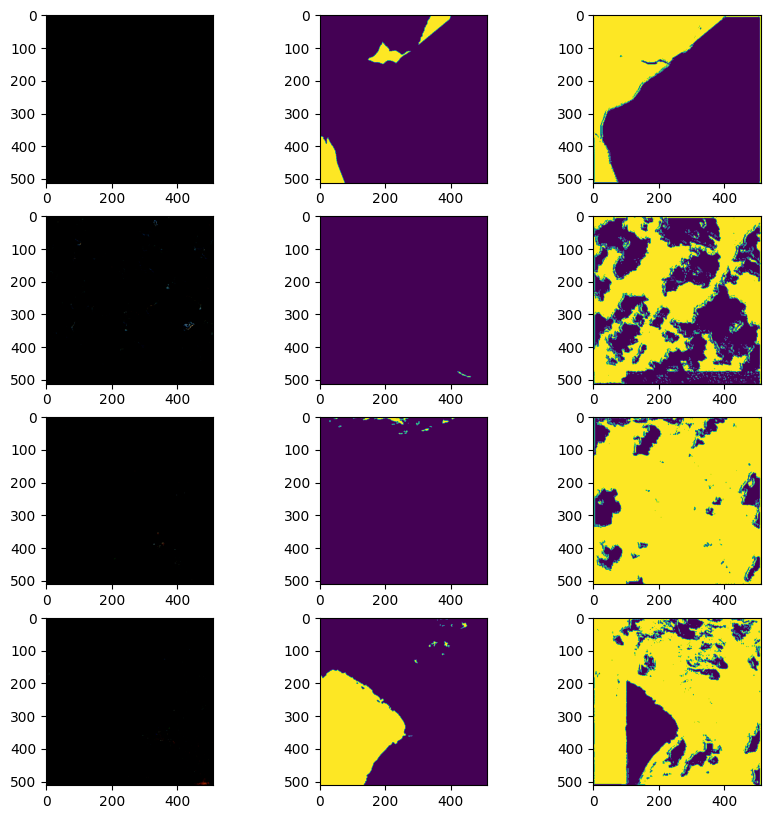

[0. 1.]


[0. 1.]
[0. 1.]
[0. 1.]


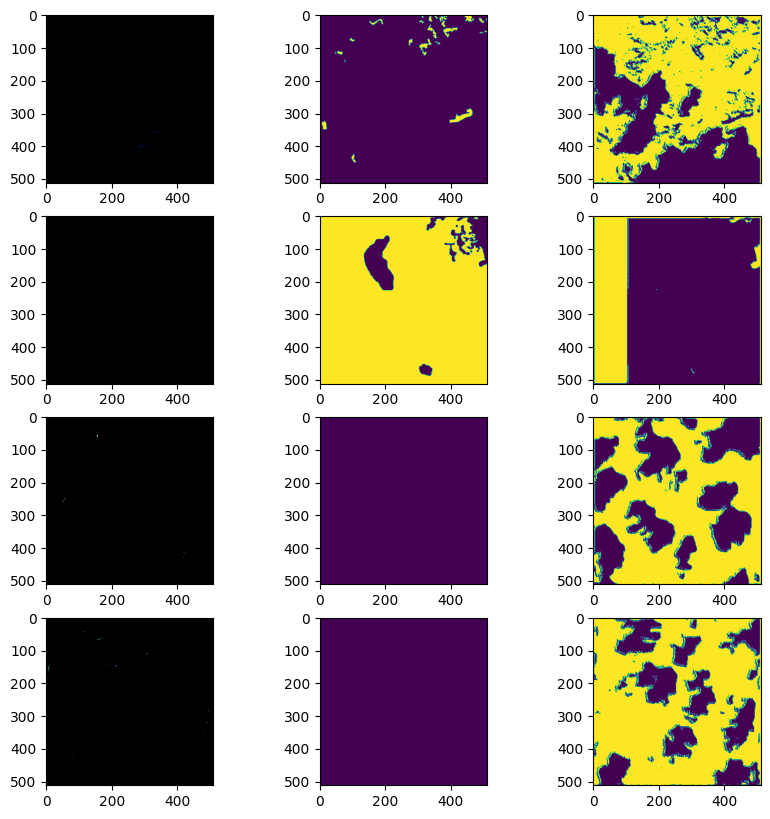

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


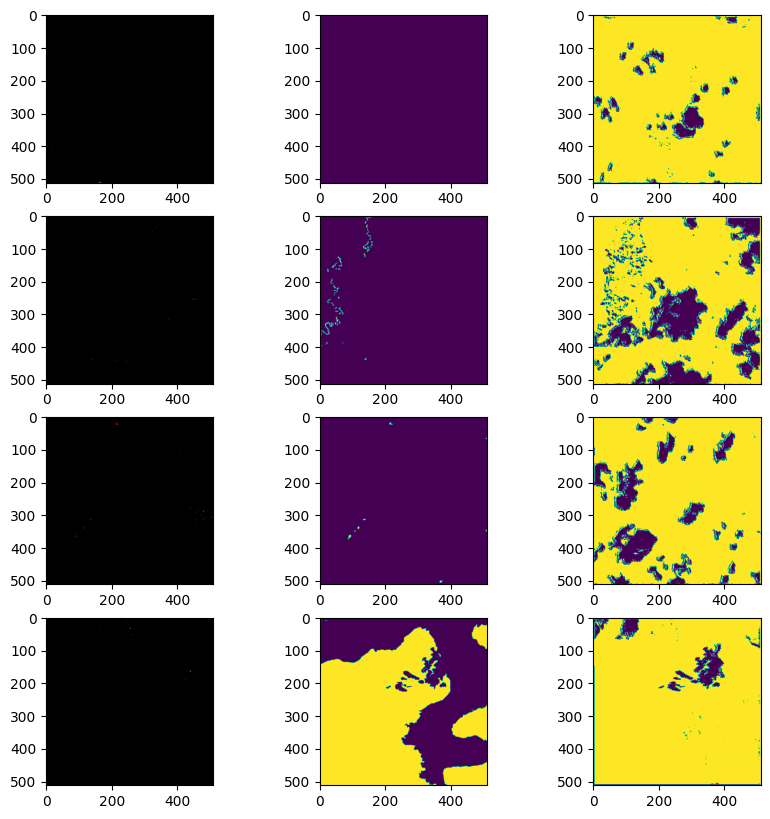

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


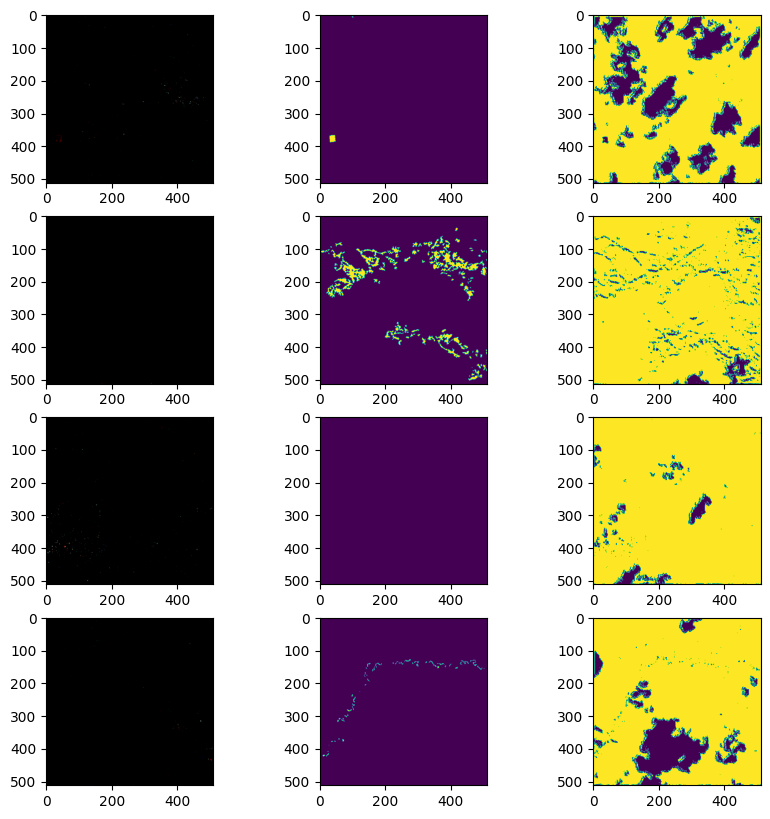

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


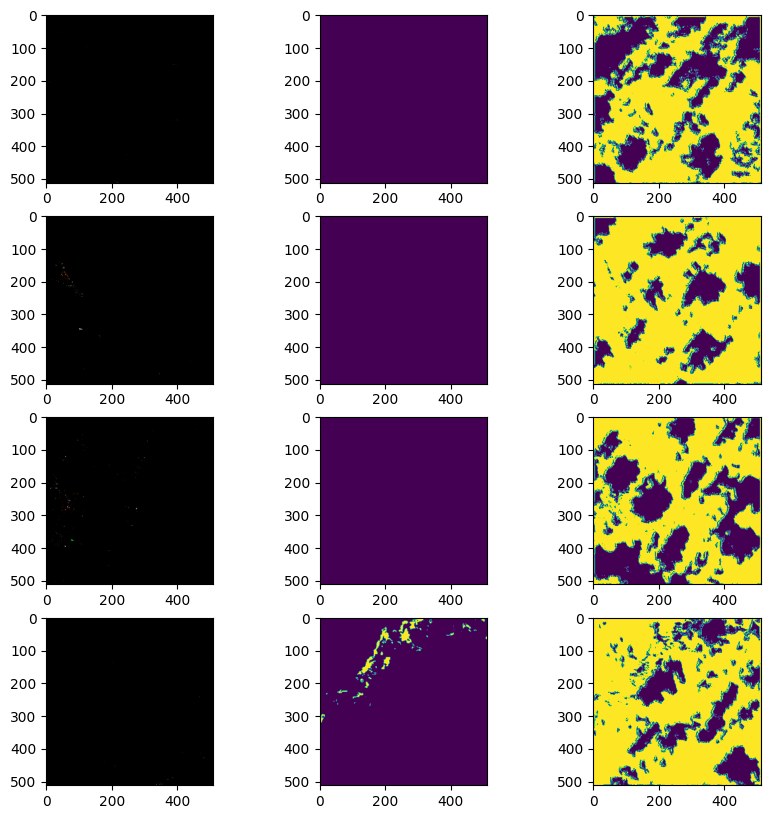

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


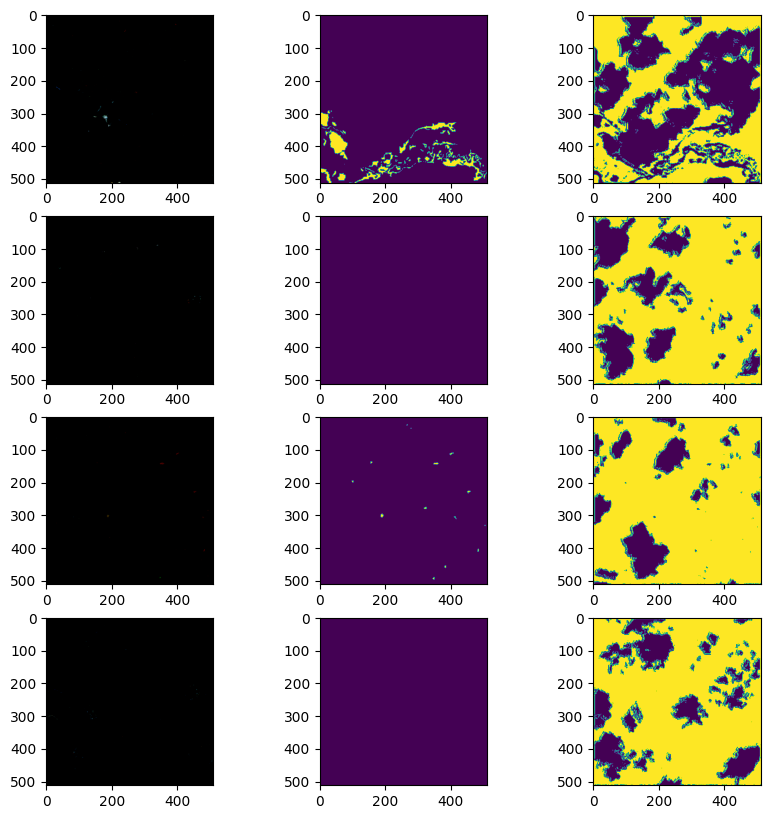

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


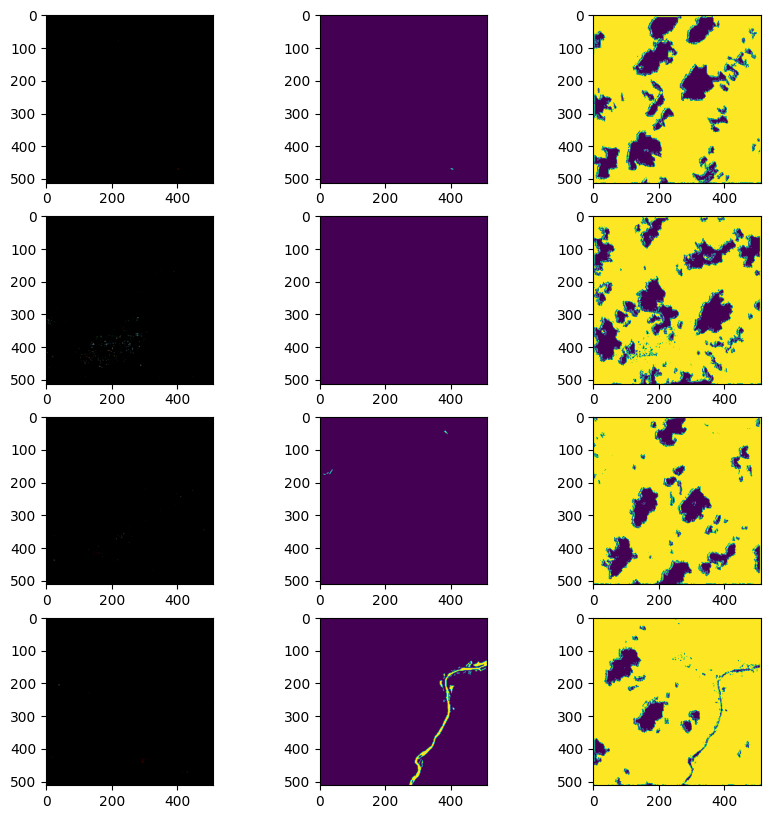

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


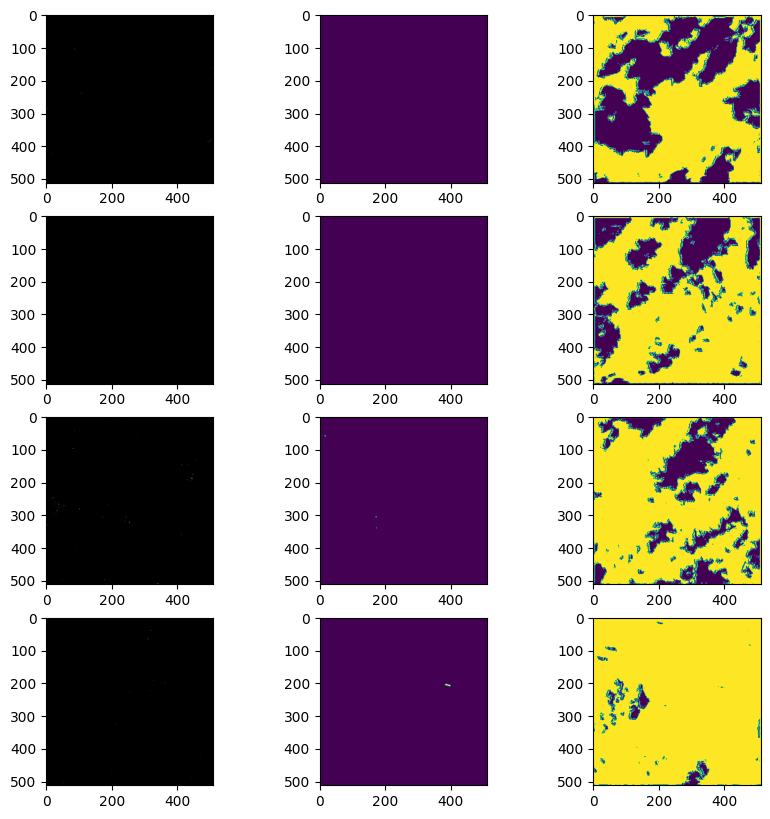

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


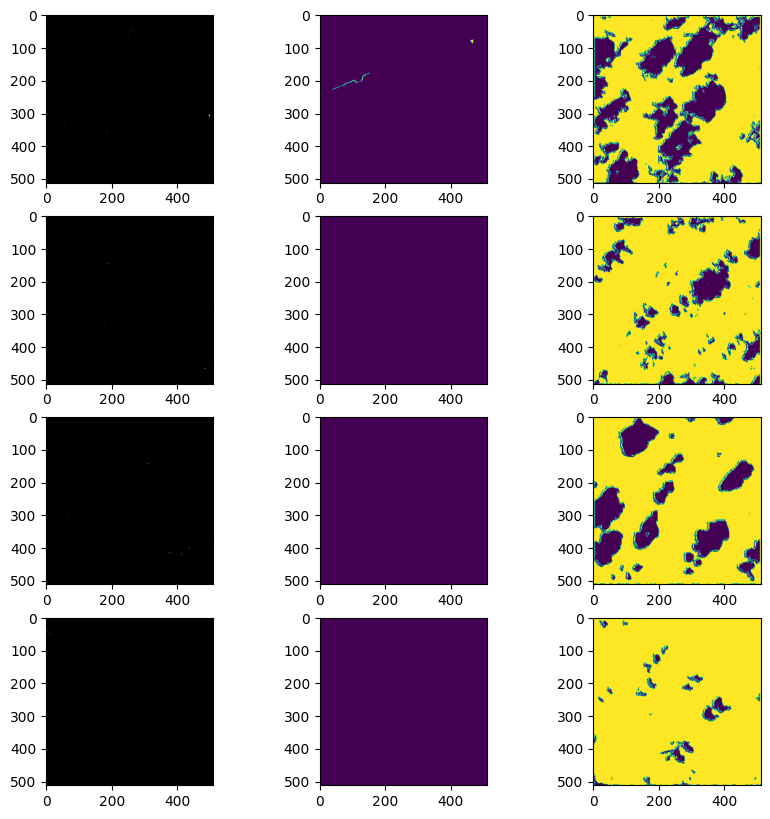

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


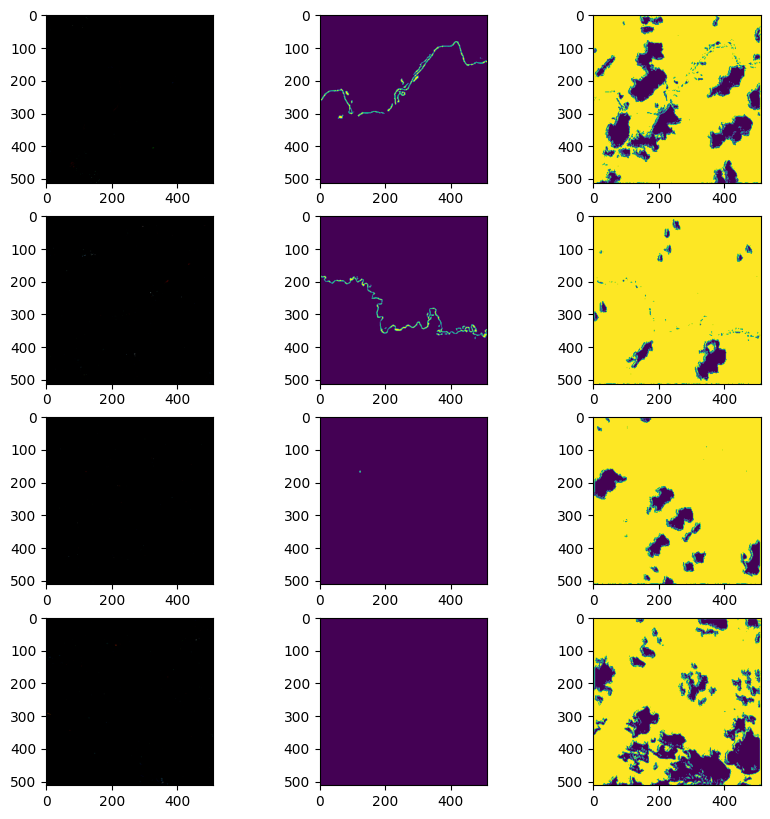

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


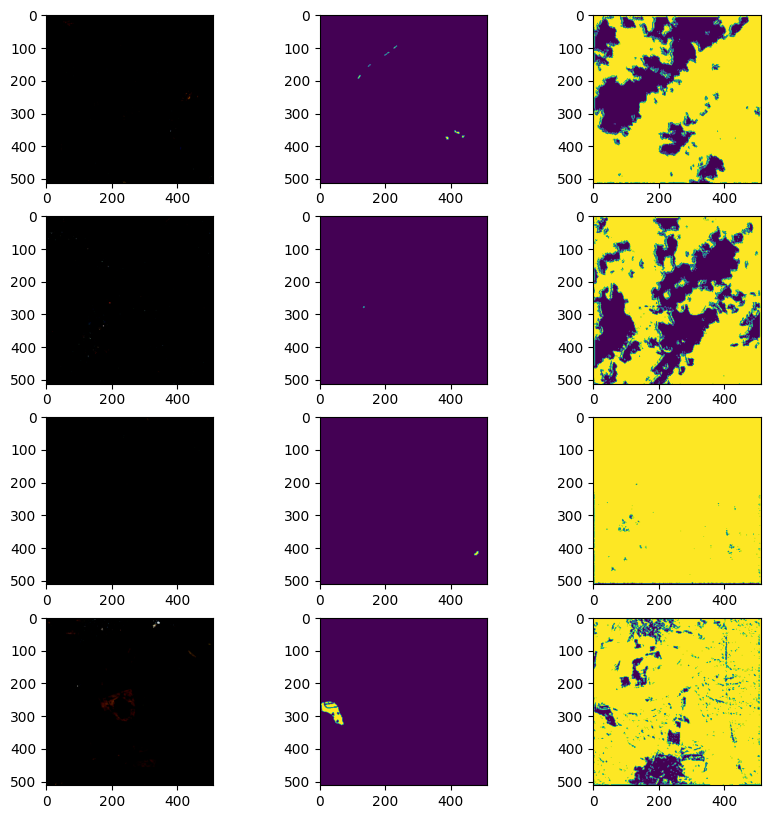

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


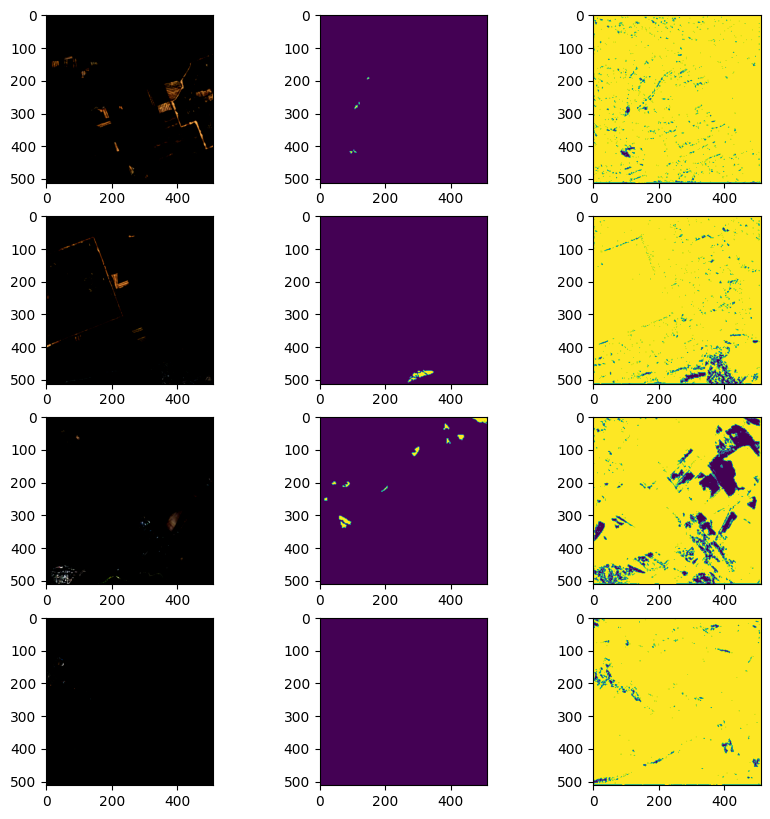

In [22]:
def plot_predictions(model, dataloader):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            #print(batch)
            x_val, y_val = batch["pixels"], batch["labels"]

            prediction = model(x_val)
            threshold = 0.003
            prediction = (prediction > threshold).float()
            #print(prediction)

            # Convert tensors to NumPy arrays for plotting
            x_val_np = x_val.cpu().numpy()
            y_val_np = y_val.cpu().numpy()
            prediction_np = prediction.cpu().numpy()

            # Plot images and masks
            num_samples = min(4, len(x_val))  # Number of samples to visualize
            fig, axes = plt.subplots(num_samples, 3, figsize=(10, 10))


            for i in range(num_samples):
                print(np.unique(prediction_np[i]))
                axes[i, 0].imshow(
                    np.transpose(
                        np.stack(
                            (
                                x_val_np[i][2, :, :],
                                x_val_np[i][1, :, :],
                                x_val_np[i][0, :, :],
                            )
                        ),
                        (1, 2, 0),
                    ) #.clip(0, 3000) / 3000 #.clip(0, 6000) / 6000
                )
                axes[i, 1].imshow(
                    np.transpose(y_val_np[i], (1, 2, 0))
                )  # Plot ground truths
                axes[i, 2].imshow(prediction_np[i].squeeze())  # Plot model predictions

            plt.show()

plot_predictions(det_model, dm.val_dataloader())

## Finetune from Clay

In [9]:
class FloodDetector(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        for param in self.encoder.parameters(): param.requires_grad = False

        self.decoder = torch.nn.Sequential(
            torch.nn.Conv2d(4608, 512, kernel_size=1, padding=0),
            torch.nn.Upsample(scale_factor=4),
            torch.nn.ConvTranspose2d(512, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=4),
            torch.nn.ConvTranspose2d(128, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1)
        )

    def forward(self, xb):
        emb = self.encoder(xb)
        embeddings = emb[0]
        embeddings = embeddings[:,:-2,:]
        latent = rearrange(embeddings, "b (g l) d  -> b g l d", g=6)
        latent = rearrange(latent, "b g (h w) d -> b g h w d", h=16, w=16)
        latent = rearrange(latent, "b g h w d -> b (g d) h w")

        logits = self.decoder(latent)
        return logits

class FloodDetectorLightning(L.LightningModule):
    def __init__(self, clay, lr=1e-3):
        super().__init__()
        self.model = FloodDetector(clay.model.encoder)
        self.model = self.model.to(clay.device)
        self.lr = lr
        self.criterion = torch.nn.BCEWithLogitsLoss()  # Suitable for segmentation tasks

    def forward(self, xb):
        return self.model(xb)

    def training_step(self, batch, batch_idx):
        targets = batch["labels"]
        logits = self(batch)
        loss = self.criterion(logits, targets)
        print("train_loss: ", loss)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch["pixels"], batch["labels"]
        outputs = self(batch)
        loss = self.criterion(outputs, targets)
        print("val_loss: ", loss)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        return optimizer

ckpt = "../clay-small-70MT-1100T-10E.ckpt"

clay = CLAYModule.load_from_checkpoint(ckpt, mask_ratio=0.0, shuffle=False)
clay.eval();

det_model_clay = FloodDetectorLightning(clay)
dm = ClayDataModule(data_dir=data_dir, batch_size=4)
dm.setup()

trainer = L.Trainer(max_epochs=5,
                    accelerator="auto",)

trainer.fit(det_model_clay,
            train_dataloaders=dm.train_dataloader(),
            val_dataloaders=dm.val_dataloader())

Total number of chips: 339


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type              | Params
------------------------------------------------
0 | model     | FloodDetector     | 98.3 M
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
3.0 M     Trainable params
95.3 M    Non-trainable params
98.3 M    Total params
393.032   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | FloodDetector     | 98.3 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val_loss:  tensor(0.7879, device='cuda:0')
val_loss:  

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


tensor(0.7724, device='cuda:0')


Training: |          | 0/? [00:00<?, ?it/s]

train_loss:  tensor(0.7931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.8049, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(1.2124, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.4467, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.2658, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.2789, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.0522, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.0541, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.7047, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.3234, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBa

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss:  tensor(0.1257, device='cuda:0')
val_loss:  tensor(0.0256, device='cuda:0')
val_loss:  tensor(0.0628, device='cuda:0')
val_loss:  tensor(2.7813, device='cuda:0')
val_loss:  tensor(0.0376, device='cuda:0')
val_loss:  tensor(0.0833, device='cuda:0')
val_loss:  tensor(1.2694, device='cuda:0')
val_loss:  tensor(0.7285, device='cuda:0')
val_loss:  tensor(0.0726, device='cuda:0')
val_loss:  tensor(0.0279, device='cuda:0')
val_loss:  tensor(0.0489, device='cuda:0')
val_loss:  tensor(0.0238, device='cuda:0')
val_loss:  tensor(0.0067, device='cuda:0')
val_loss:  tensor(0.0074, device='cuda:0')
val_loss:  tensor(0.0364, device='cuda:0')
val_loss:  tensor(0.0168, device='cuda:0')
val_loss:  tensor(0.0258, device='cuda:0')
train_loss:  tensor(0.1381, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.0378, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.7379, device='cuda:0',
       grad_fn=<Binary

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss:  tensor(0.1495, device='cuda:0')
val_loss:  tensor(0.0320, device='cuda:0')
val_loss:  tensor(0.0557, device='cuda:0')
val_loss:  tensor(1.4871, device='cuda:0')
val_loss:  tensor(0.0268, device='cuda:0')
val_loss:  tensor(0.0578, device='cuda:0')
val_loss:  tensor(0.8068, device='cuda:0')
val_loss:  tensor(0.5463, device='cuda:0')
val_loss:  tensor(0.0568, device='cuda:0')
val_loss:  tensor(0.0279, device='cuda:0')
val_loss:  tensor(0.0404, device='cuda:0')
val_loss:  tensor(0.0250, device='cuda:0')
val_loss:  tensor(0.0102, device='cuda:0')
val_loss:  tensor(0.0099, device='cuda:0')
val_loss:  tensor(0.0367, device='cuda:0')
val_loss:  tensor(0.0233, device='cuda:0')
val_loss:  tensor(0.0382, device='cuda:0')
train_loss:  tensor(0.1471, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.0507, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.0603, device='cuda:0',
       grad_fn=<Binary

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss:  tensor(0.1293, device='cuda:0')
val_loss:  tensor(0.0261, device='cuda:0')
val_loss:  tensor(0.0776, device='cuda:0')
val_loss:  tensor(1.7244, device='cuda:0')
val_loss:  tensor(0.0225, device='cuda:0')
val_loss:  tensor(0.0821, device='cuda:0')
val_loss:  tensor(0.9537, device='cuda:0')
val_loss:  tensor(0.6134, device='cuda:0')
val_loss:  tensor(0.0637, device='cuda:0')
val_loss:  tensor(0.0280, device='cuda:0')
val_loss:  tensor(0.0384, device='cuda:0')
val_loss:  tensor(0.0270, device='cuda:0')
val_loss:  tensor(0.0056, device='cuda:0')
val_loss:  tensor(0.0060, device='cuda:0')
val_loss:  tensor(0.0494, device='cuda:0')
val_loss:  tensor(0.0160, device='cuda:0')
val_loss:  tensor(0.0221, device='cuda:0')
train_loss:  tensor(0.0035, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.4388, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.0559, device='cuda:0',
       grad_fn=<Binary

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss:  tensor(0.1410, device='cuda:0')
val_loss:  tensor(0.0254, device='cuda:0')
val_loss:  tensor(0.0605, device='cuda:0')
val_loss:  tensor(1.1834, device='cuda:0')
val_loss:  tensor(0.0189, device='cuda:0')
val_loss:  tensor(0.0485, device='cuda:0')
val_loss:  tensor(0.8997, device='cuda:0')
val_loss:  tensor(0.5590, device='cuda:0')
val_loss:  tensor(0.0582, device='cuda:0')
val_loss:  tensor(0.0231, device='cuda:0')
val_loss:  tensor(0.0425, device='cuda:0')
val_loss:  tensor(0.0212, device='cuda:0')
val_loss:  tensor(0.0040, device='cuda:0')
val_loss:  tensor(0.0051, device='cuda:0')
val_loss:  tensor(0.0471, device='cuda:0')
val_loss:  tensor(0.0143, device='cuda:0')
val_loss:  tensor(0.0274, device='cuda:0')
train_loss:  tensor(0.1938, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.1982, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train_loss:  tensor(0.1772, device='cuda:0',
       grad_fn=<Binary

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss:  tensor(0.1688, device='cuda:0')
val_loss:  tensor(0.0369, device='cuda:0')
val_loss:  tensor(0.0533, device='cuda:0')
val_loss:  tensor(0.9968, device='cuda:0')
val_loss:  tensor(0.0254, device='cuda:0')
val_loss:  tensor(0.0436, device='cuda:0')
val_loss:  tensor(0.7116, device='cuda:0')
val_loss:  tensor(0.4137, device='cuda:0')
val_loss:  tensor(0.0566, device='cuda:0')
val_loss:  tensor(0.0316, device='cuda:0')
val_loss:  tensor(0.0438, device='cuda:0')
val_loss:  tensor(0.0277, device='cuda:0')
val_loss:  tensor(0.0142, device='cuda:0')
val_loss:  tensor(0.0128, device='cuda:0')
val_loss:  tensor(0.0393, device='cuda:0')
val_loss:  tensor(0.0277, device='cuda:0')
val_loss:  tensor(0.0422, device='cuda:0')


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


prediction values:  [0. 1.]


[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


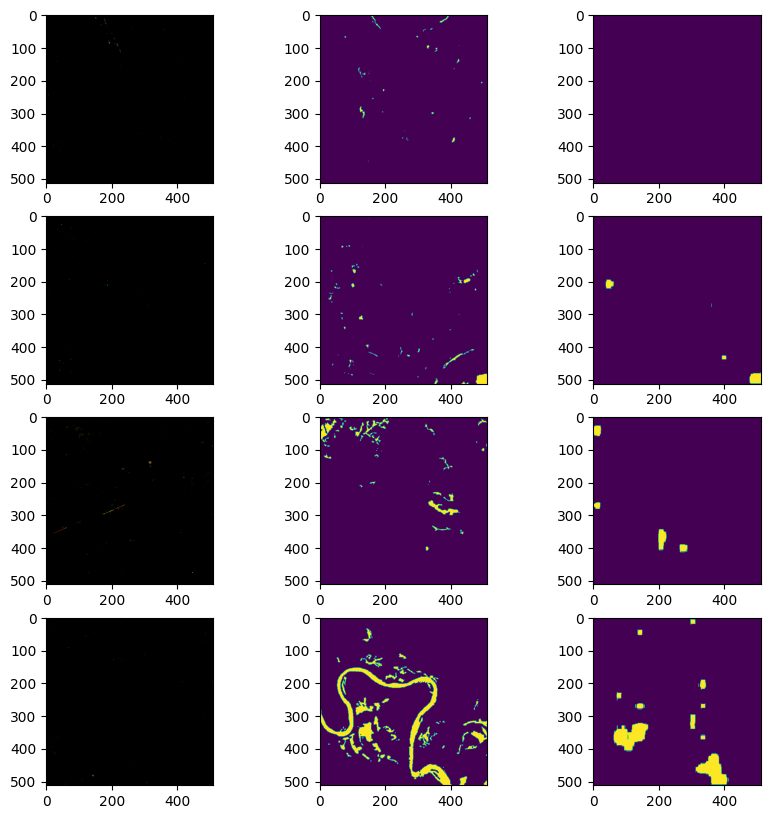

prediction values:  [0. 1.]


[0.]
[0.]
[0. 1.]
[0.]


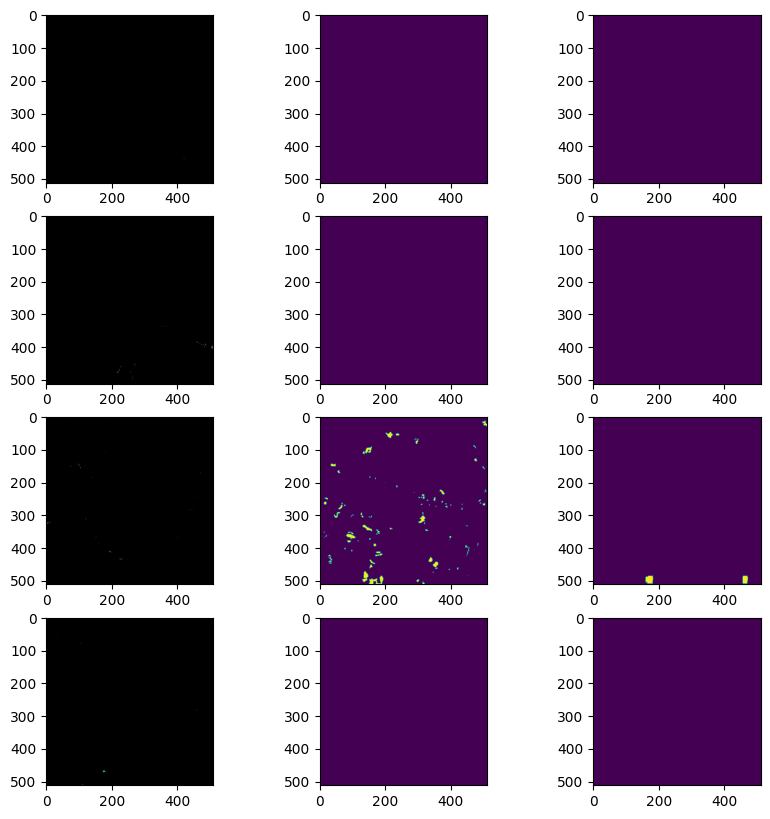

prediction values:  [0. 1.]


[0. 1.]
[0. 1.]
[0. 1.]
[0.]


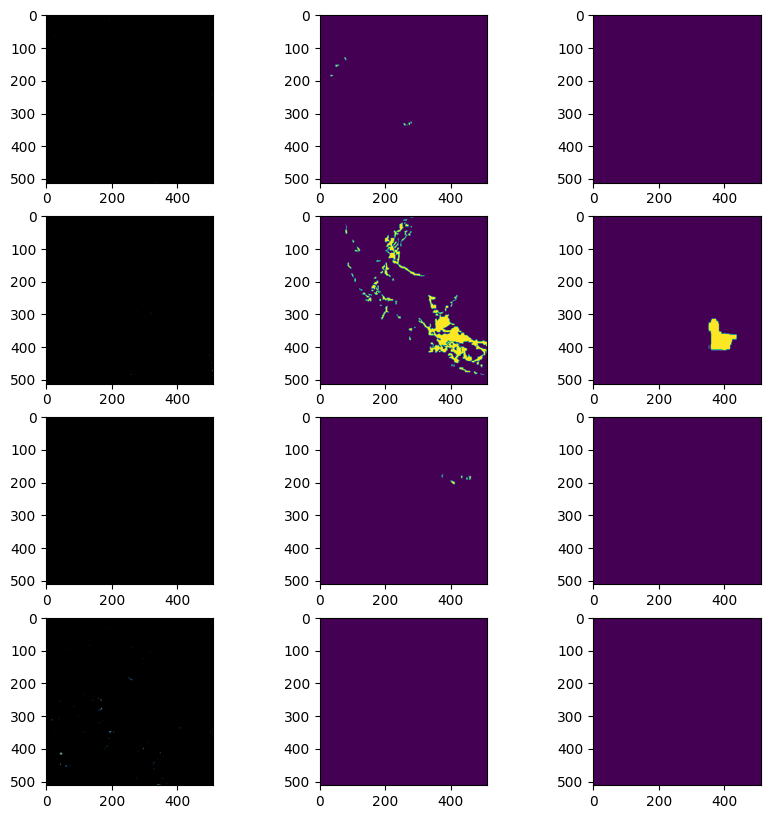

prediction values:  [0. 1.]


[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


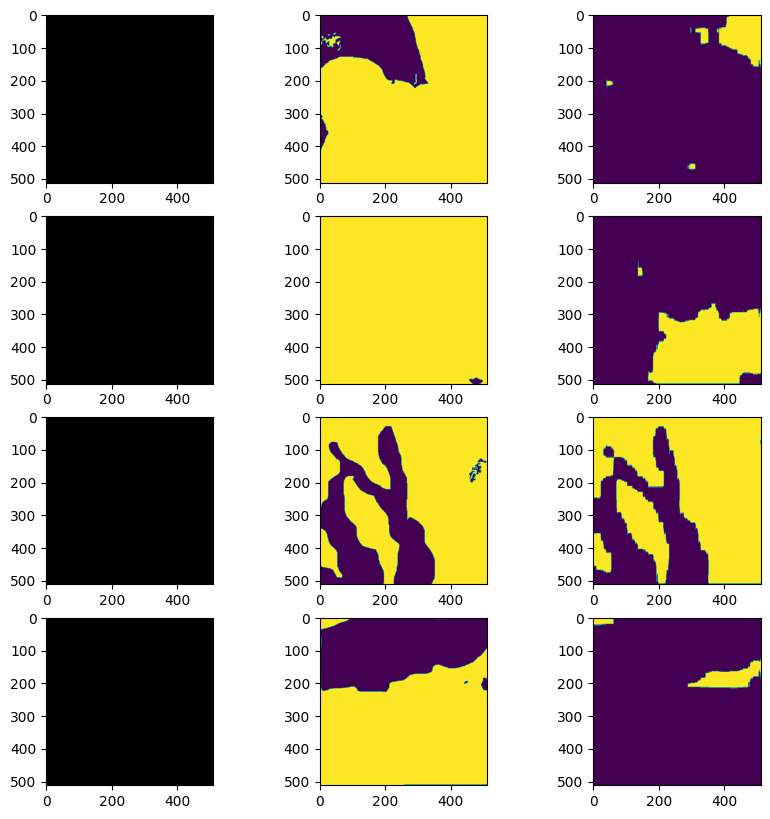

prediction values:  [0. 1.]
[0.]
[0.]


[0. 1.]
[0. 1.]


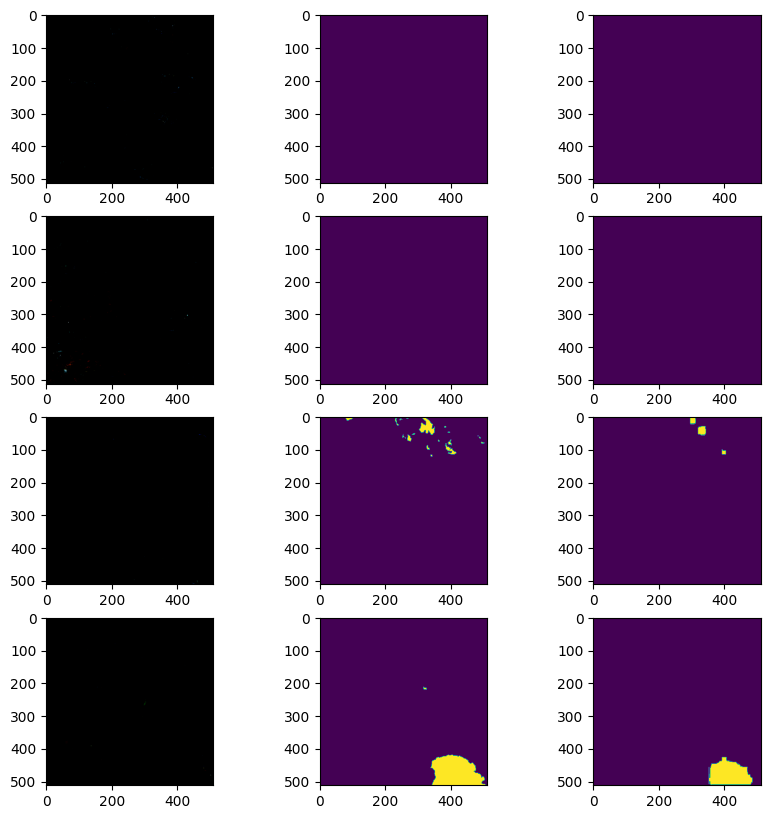

prediction values:  [0. 1.]


[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


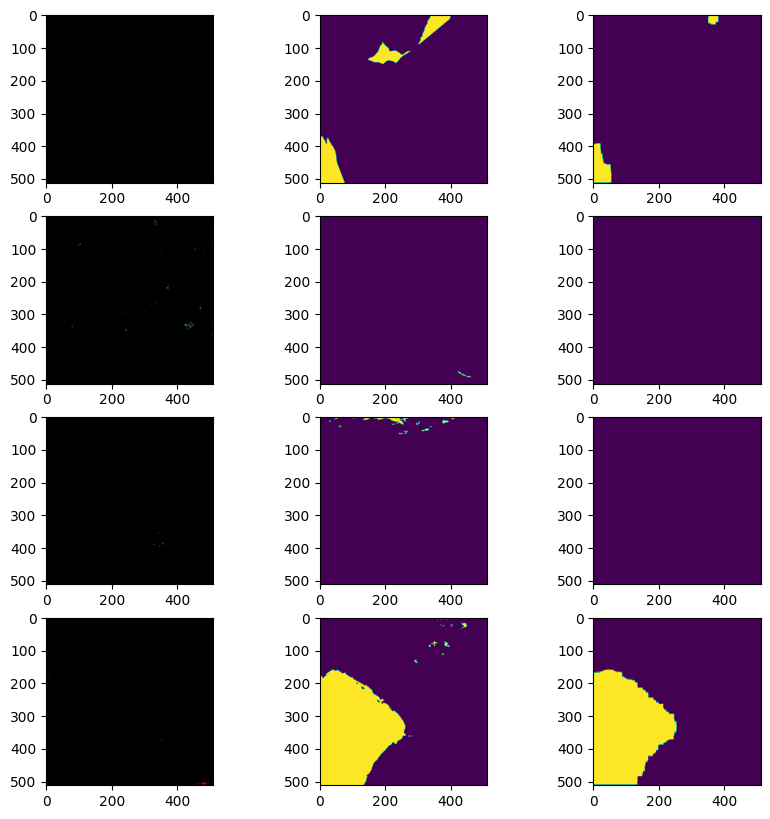

prediction values:  [0. 1.]
[0. 1.]
[0. 1.]


[0.]
[0.]


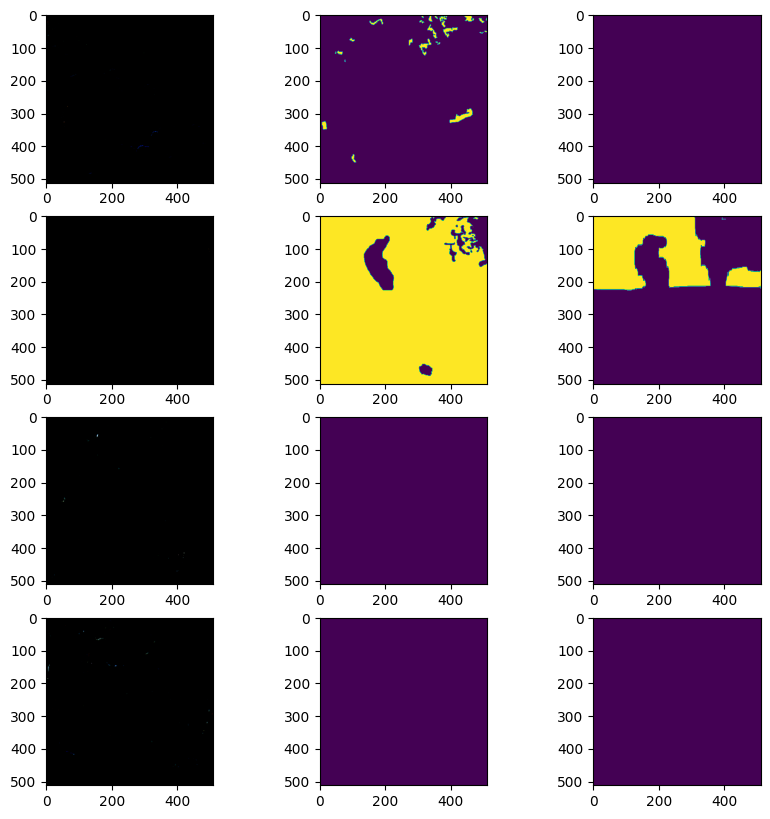

prediction values:  [0. 1.]
[0.]


[0. 1.]
[0. 1.]
[0. 1.]


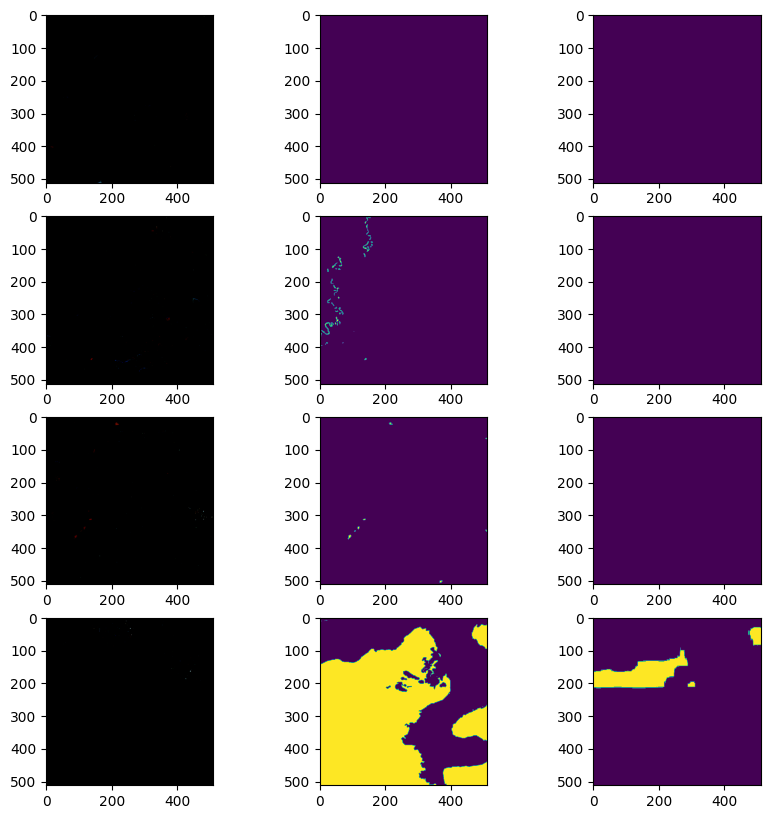

prediction values:  [0. 1.]
[0. 1.]
[0. 1.]
[0.]
[0. 1.]


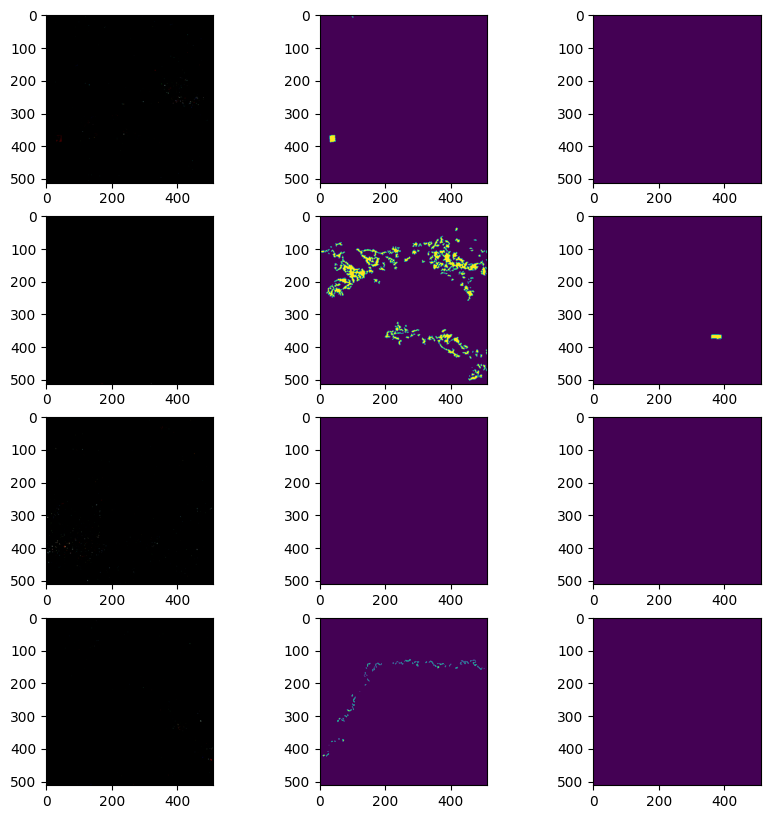

prediction values:  [0. 1.]
[0.]
[0.]
[0.]


[0. 1.]


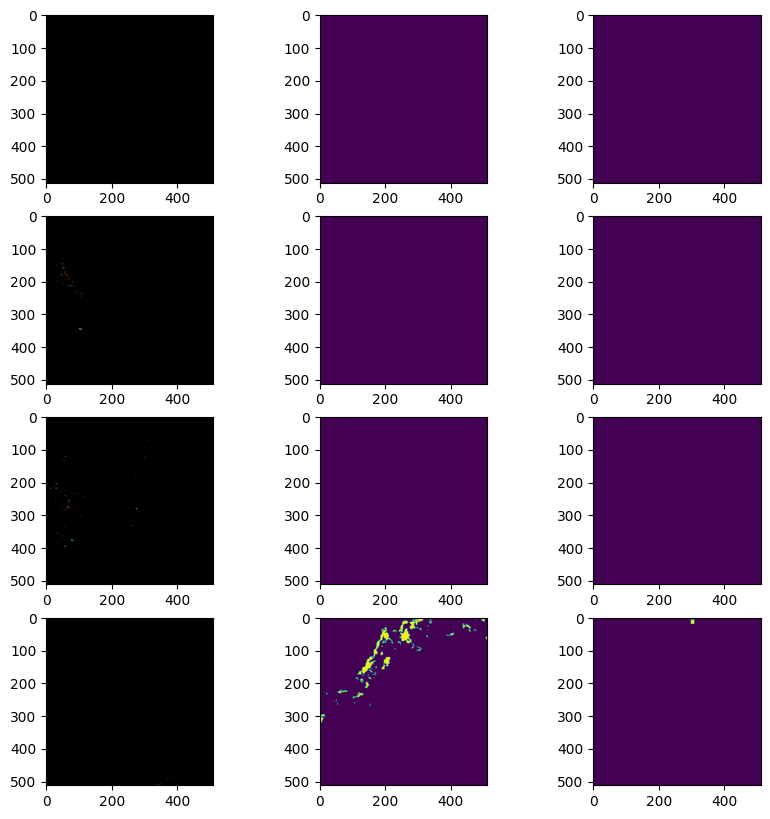

prediction values:  [0. 1.]


[0. 1.]
[0.]
[0. 1.]
[0.]


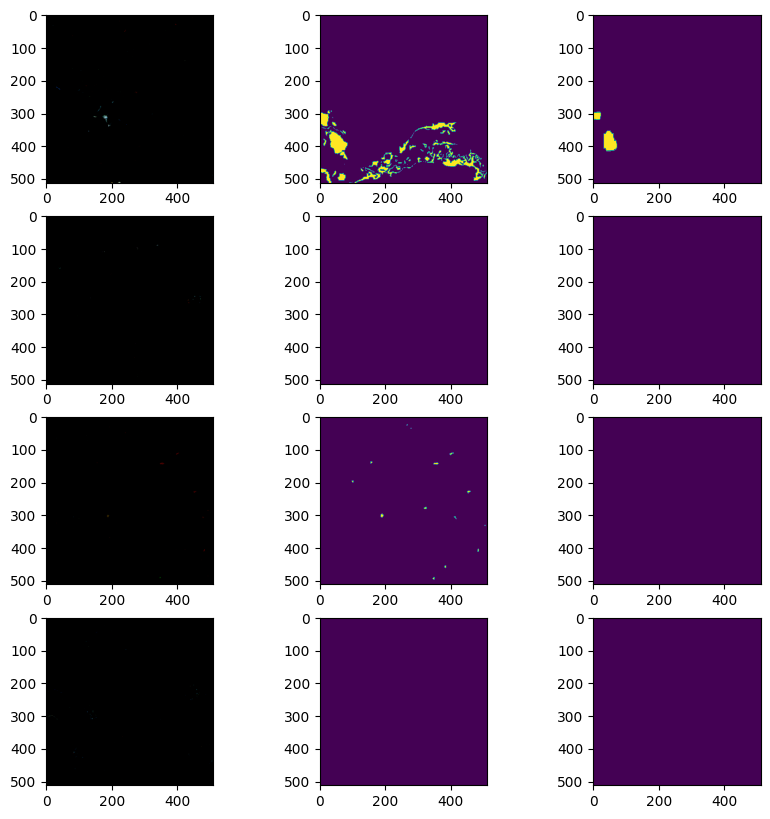

prediction values:  [0.]


[0. 1.]
[0.]
[0. 1.]
[0. 1.]


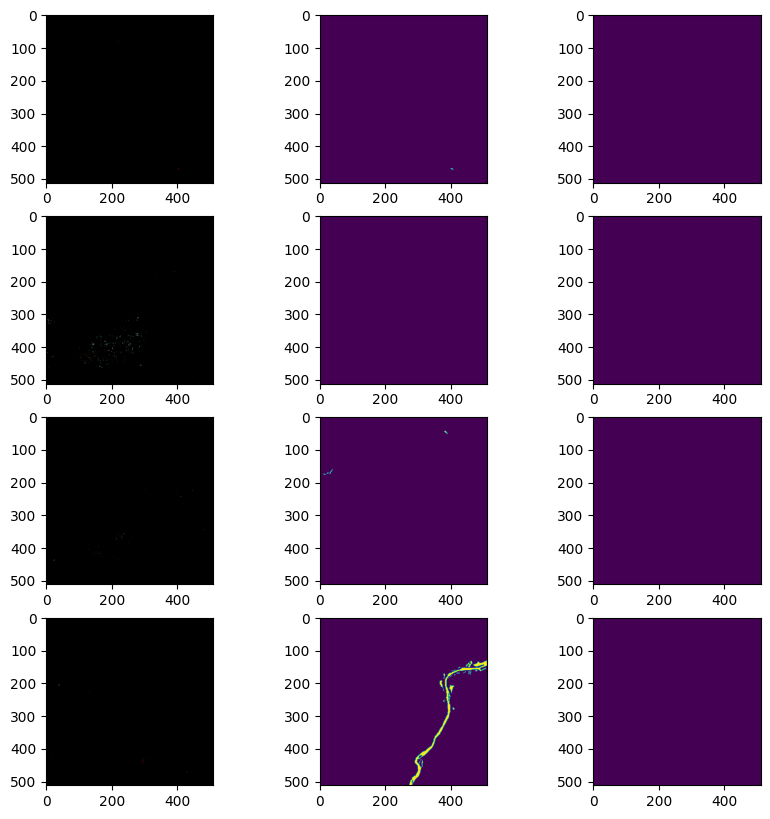

prediction values:  [0.]
[0.]


[0.]
[0. 1.]
[0. 1.]


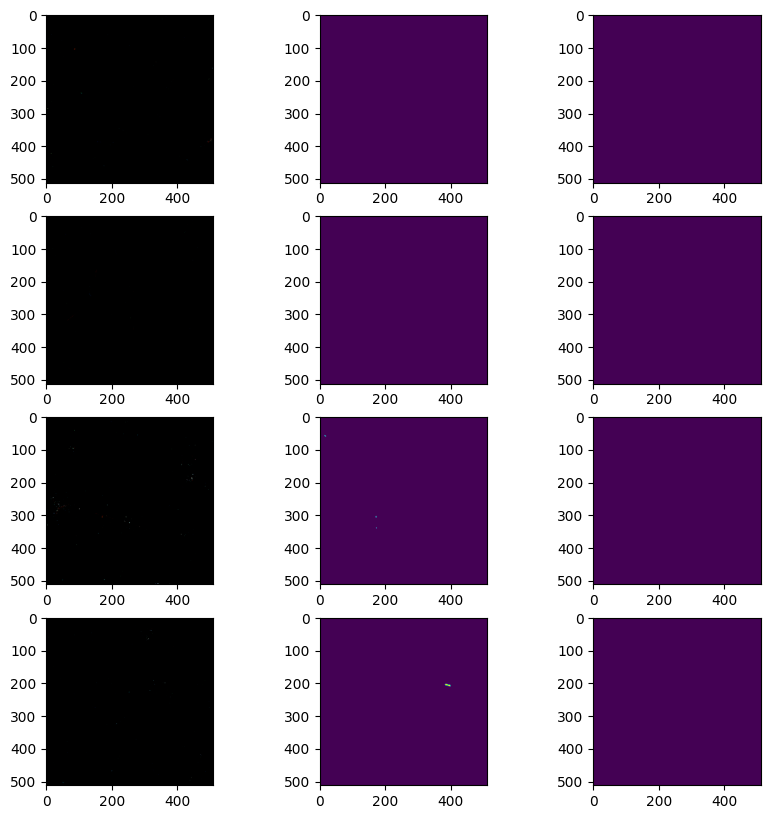

prediction values:  [0.]
[0. 1.]


[0.]
[0.]
[0.]


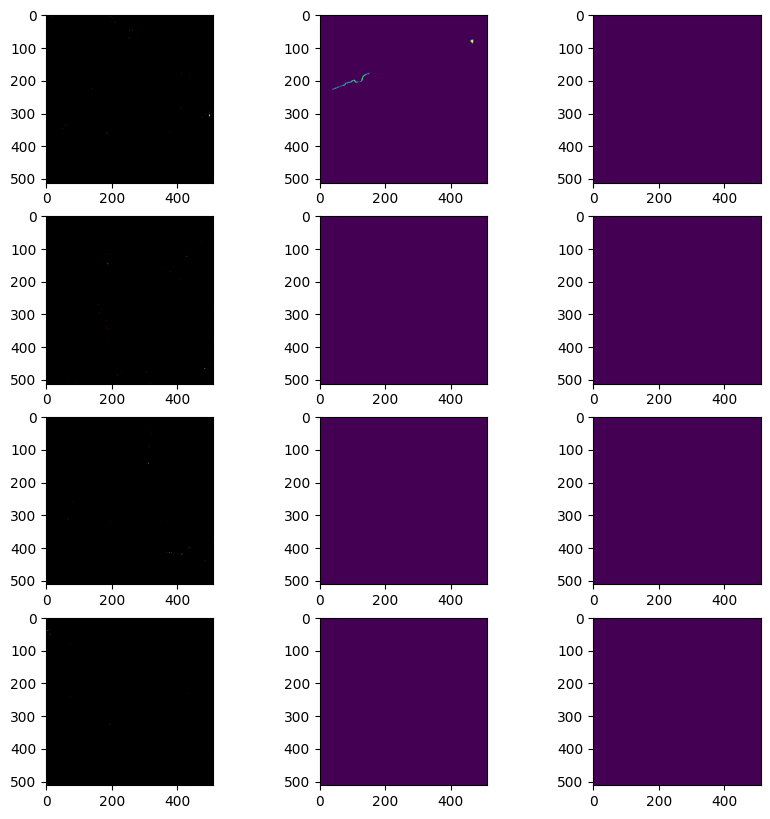

prediction values:  [0.]
[0. 1.]
[0. 1.]


[0. 1.]
[0.]


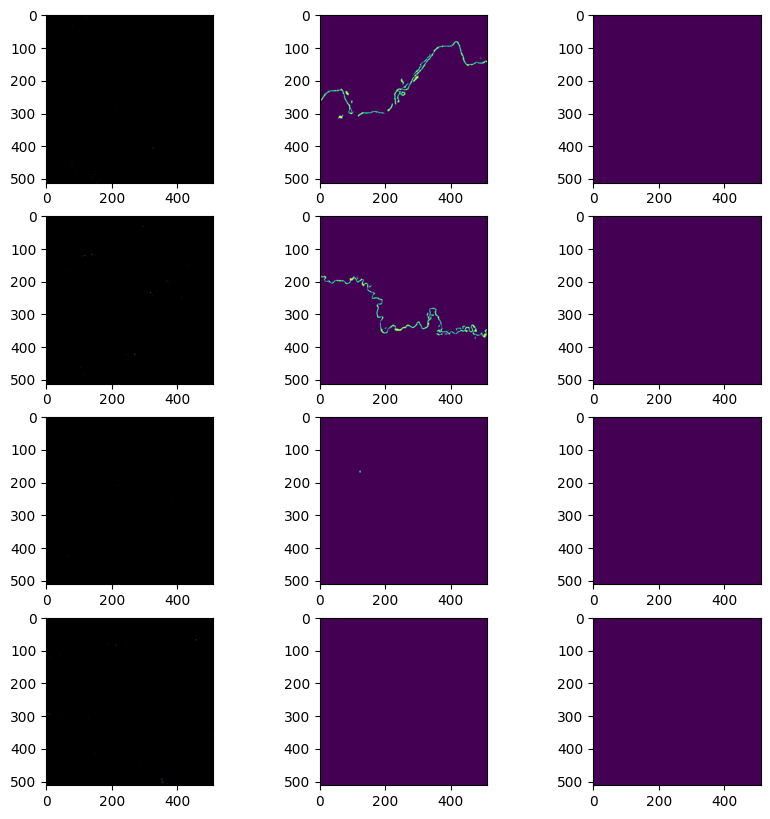

prediction values:  [0.]
[0. 1.]
[0. 1.]


[0. 1.]
[0. 1.]


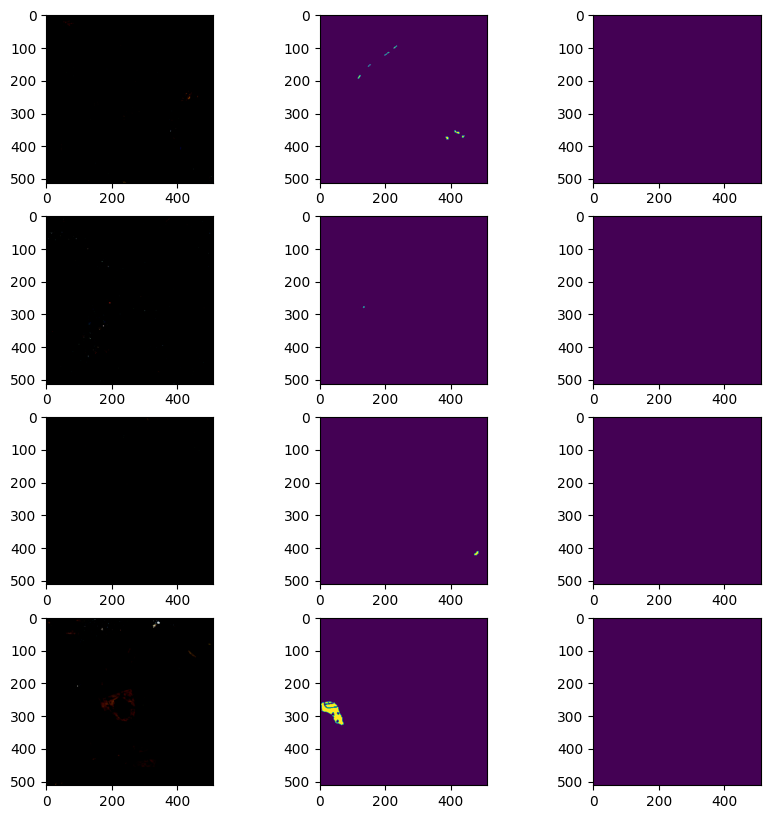

prediction values:  [0. 1.]
[0. 1.]
[0. 1.]


[0. 1.]
[0.]


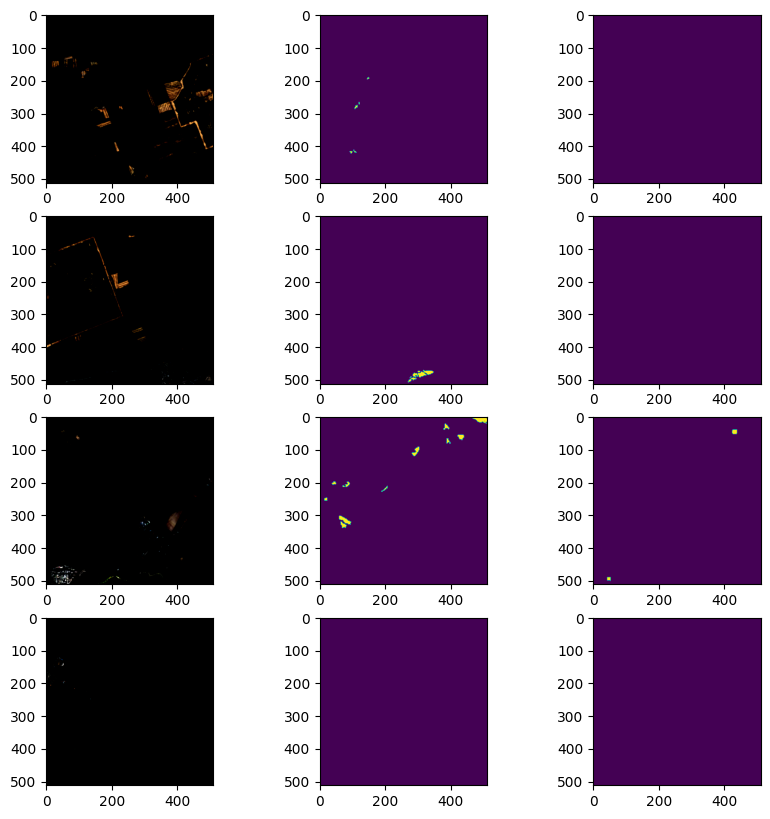

In [10]:
def plot_predictions(model, dataloader):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            #print(batch)
            x_val, y_val = batch["pixels"], batch["labels"]
            prediction = model(batch)
            prediction = (prediction > 0.3).float()

            # Convert tensors to NumPy arrays for plotting
            x_val_np = x_val.cpu().numpy()
            y_val_np = y_val.cpu().numpy()
            prediction_np = prediction.cpu().numpy()
            print("prediction values: ", np.unique(prediction_np))

            # Plot images and masks
            num_samples = min(4, len(x_val))  # Number of samples to visualize
            fig, axes = plt.subplots(num_samples, 3, figsize=(10, 10))

            for i in range(num_samples):
                print(np.unique(y_val_np[i]))
                axes[i, 0].imshow(
                    np.transpose(
                        np.stack(
                            (
                                x_val_np[i][2, :, :],
                                x_val_np[i][1, :, :],
                                x_val_np[i][0, :, :],
                            )
                        ),
                        (1, 2, 0),
                    )
                )   # Plot input images
                axes[i, 1].imshow(
                    np.transpose(y_val_np[i], (1, 2, 0))
                )  # Plot ground truths
                axes[i, 2].imshow(prediction_np[i].squeeze())  # Plot model predictions

            plt.show()

plot_predictions(det_model_clay, dm.val_dataloader())


In [15]:
def calculate_IoU(model, dataloader, clay=False):
    model.eval()
    IoUs = []
    with torch.no_grad():
        for batch in dataloader:
            x_val, y_val = batch["pixels"], batch["labels"]
            threshold = 0.3
            if clay==True:
              prediction = model(batch)
              prediction = (torch.sigmoid(prediction) > threshold).float()
            else:
              prediction = model(x_val)
              prediction = (prediction > threshold).float()

            # Calculate IoU using torchmetrics
            iou_metric = torchmetrics.JaccardIndex(task="binary", num_classes=2)  # Assuming binary segmentation (2 classes: 0 and 1)
            iou = iou_metric(prediction, y_val)
            IoUs.append(iou)

            print(f'IoU: {iou.item()}')
    return IoUs

In [23]:
IoUs = calculate_IoU(det_model, dm.val_dataloader(), clay=False)

IoUs_thresholded = [value for value in IoUs if value > 0.5]

average_IoU = sum(IoUs) / len(IoUs)

print(f'Average IoU: {average_IoU}')

IoU: 0.03585243225097656
IoU: 0.004599571228027344
IoU: 0.01620960235595703
IoU: 0.7885646820068359
IoU: 0.013516426086425781
IoU: 0.07680988311767578
IoU: 0.23628902435302734
IoU: 0.14336395263671875
IoU: 0.017548561096191406
IoU: 0.0060138702392578125
IoU: 0.013129234313964844
IoU: 0.0045318603515625
IoU: 9.250640869140625e-05
IoU: 0.000286102294921875
IoU: 0.006142616271972656
IoU: 0.0022916793823242188
IoU: 0.0034818649291992188
Average IoU: 0.08051317185163498


In [17]:
IoUs = calculate_IoU(det_model_clay, dm.val_dataloader(), clay=True)

IoUs_thresholded = [value for value in IoUs if value > 0.5]

average_IoU = sum(IoUs) / len(IoUs)

print(f'Average IoU from model finetuned from Clay: {average_IoU}')

IoU: 0.15495245158672333
IoU: 0.07963650673627853
IoU: 0.31689271330833435
IoU: 0.7631623148918152
IoU: 0.664329469203949
IoU: 0.823370099067688
IoU: 0.3466169834136963
IoU: 0.2260919064283371
IoU: 0.21468259394168854
IoU: 0.19329631328582764
IoU: 0.23902466893196106
IoU: 0.12468703091144562
IoU: 0.0
IoU: 0.0
IoU: 0.0005432568141259253
IoU: 0.0
IoU: 0.06927777081727982
Average IoU from model finetuned from Clay: 0.24803316593170166
